In [1]:
%load_ext autoreload
%autoreload 2

import sys
from itertools import groupby

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision.transforms.functional as TF
from colorama import Fore
from torchvision import datasets, transforms
from tqdm import tqdm

## 1. Parameters configuration

In [3]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# ============================================= PREPARING DATASET ======================================================
epochs = 5
num_classes = 11
blank_label = 10
image_height = 28
gru_hidden_size = 128
gru_num_layers = 2
cnn_output_height = 4
cnn_output_width = 32
digits_per_sequence = 5
number_of_sequences = 10000  # 10000
emnist_dataset = datasets.EMNIST('./EMNIST', split="digits", train=True, download=True)
dataset_sequences = []
dataset_labels = []

## 2. Data preparation

torch.Size([240000, 28, 28]) torch.Size([28, 28]) tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   2,  21,  37,  21,   3,   0,   0,   

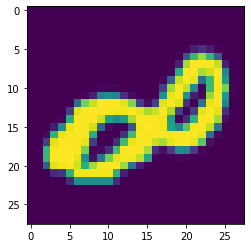

In [4]:
print(emnist_dataset.data.shape, emnist_dataset.data[0].shape, emnist_dataset.data[0])
img = emnist_dataset.data[0].cpu().detach().numpy()
plt.imshow(img)
plt.show()

In [5]:
## Data sampling and preparation (rotate and flip images with regular angle)
# Combine 5 digits as one sample
for i in range(number_of_sequences):
    random_indices = np.random.randint(len(emnist_dataset.data), size=(digits_per_sequence,)) # Randomize the index (len(index)=5)
    #print(random_indices)
    random_digits_images = emnist_dataset.data[random_indices] # Data sampling based on randomized indexes
    #print(random_digits_images.shape)
    transformed_random_digits_images = []

    for img in random_digits_images:
        #plt.imshow(img.cpu().detach().numpy())
        #plt.show()
        img = transforms.ToPILImage()(img)
        #img.show()
        img = TF.rotate(img, -90, fill=0) # Rotate original image with degree
        #img.show()
        img = TF.hflip(img) # Flip the rotated image
        #img.show()
        img = transforms.RandomAffine(degrees=10, translate=(0.2, 0.15), scale=(0.8, 1.1))(img)
        #img.show()
        img = transforms.ToTensor()(img).numpy() # Convert PIL.Image.Image to array
        #print(type(img))
        transformed_random_digits_images.append(img)
        # print(len(transformed_random_digits_images))
    
    #print(len(transformed_random_digits_images), transformed_random_digits_images[0].shape) # 5, (1, 28, 28)
    random_digits_images = np.array(transformed_random_digits_images)
    #print(random_digits_images.shape) #(5, 1, 28, 28)
    random_digits_labels = emnist_dataset.targets[random_indices] # Obtain the labels for the images
    #print(random_digits_labels.shape, random_digits_labels) # Sample: torch.Size([5]), tensor([6, 6, 7, 9, 7])
    #print(random_digits_images.reshape((digits_per_sequence, 28, 28)).shape)
    random_sequence = np.hstack(random_digits_images.reshape((digits_per_sequence, 28, 28))) # Combine 5 images into one image (a sequence of digits)
    #print(random_sequence.shape, random_sequence[0].shape) # (28, 140), (140,)
    random_labels = np.hstack(random_digits_labels.reshape(digits_per_sequence, 1))
    #print(random_labels.shape, random_labels) # (5,), [8 4 8 3 1]
    dataset_sequences.append(random_sequence / 255) # Normalize the array (image array)
    dataset_labels.append(random_labels)
    
""" How data in different shape are mapped """
print(dataset_sequences[0].shape, dataset_labels[0].shape) # (28, 140), (5,)

(28, 140) (5,)


10000
(28, 140)
(5,)


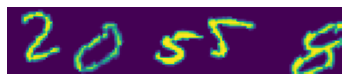

In [6]:
print(len(dataset_sequences))
print(dataset_sequences[1].shape)
print(dataset_labels[1].shape) # dataset_labels.cpu().detach().numpy()[0:3]
img = dataset_sequences[6]
plt.imshow(img)
plt.axis('off')
plt.show()

In [7]:
dataset_data = torch.Tensor(np.array(dataset_sequences)) # to tensors
dataset_labels = torch.IntTensor(np.array(dataset_labels)) # to tensors
print(dataset_data.shape, dataset_labels.shape)

seq_dataset = data_utils.TensorDataset(dataset_data, dataset_labels) # Dataset wrapping tensors with (inputs, targets) - arguments are tensors
train_set, val_set = torch.utils.data.random_split(seq_dataset,[int(len(seq_dataset) * 0.8), int(len(seq_dataset) * 0.2)])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True)

torch.Size([10000, 28, 140]) torch.Size([10000, 5])


## 3. Model Configuration

In [8]:
# ================================================= MODEL ==============================================================
class CRNN(nn.Module):

    def __init__(self):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3))
        self.norm1 = nn.InstanceNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2)
        self.norm2 = nn.InstanceNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.norm3 = nn.InstanceNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=2)
        self.norm4 = nn.InstanceNorm2d(64)
        self.gru_input_size = cnn_output_height * 64
        self.gru = nn.GRU(self.gru_input_size, gru_hidden_size, gru_num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

    def forward(self, x):
        # forward performs the actual computation and outputs a prediction, given the input x.
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.norm1(out)
        out = F.leaky_relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = F.leaky_relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out = F.leaky_relu(out)
        out = self.conv4(out)
        out = self.norm4(out)
        out = F.leaky_relu(out)
        out = out.permute(0, 3, 2, 1)
        out = out.reshape(batch_size, -1, self.gru_input_size)
        out, _ = self.gru(out)
        out = torch.stack([F.log_softmax(self.fc(out[i]), dim=-1) for i in range(out.shape[0])])
        return out
    
model = CRNN().to(gpu)
criterion = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 4. Model training

In [11]:
# ================================================ TRAINING MODEL ======================================================
# epochs = 2
for _ in range(epochs):
    # ============================================ TRAINING ============================================================
    train_correct = 0
    train_total = 0
    for x_train, y_train in tqdm(train_loader,
                                 position=0, leave=True,
                                 file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)): # Iterate each batch
        batch_size = x_train.shape[0]  # x_train.shape == torch.Size([64, 28, 140])
        x_train = x_train.view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]) # Fast and memory efficient reshaping
        optimizer.zero_grad()
        y_pred = model(x_train) # x_train.cuda() when GPU is available, Encoded prediction
        """ """
        y_no_permute = y_pred
        # permute: swap the axes, (1, 0, 2) means axis 1 and 0 exchange, axis 2 is unchanged
        y_pred = y_pred.permute(1, 0, 2)  # y_pred.shape == torch.Size([64, 32, 11]) - y_pred.shape = [batch_size, time_steps, # of classes]
        y_train_permute = y_pred
        """ """
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_train])
        
        loss = criterion(y_pred, y_train, input_lengths, target_lengths) # Computes loss
        loss.backward() # Computes gradients of all parameters
        optimizer.step() # Performs the updates on parameters
        
        # Calculate training performance on training dataset
        _, max_index = torch.max(y_pred, dim=2)  # max_index.shape == torch.Size([32, 64])
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())  # len(raw_prediction) == 32
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_train[i]) and torch.all(prediction.eq(y_train[i])):
                train_correct += 1
            train_total += 1
    print('TRAINING. Correct: ', train_correct, '/', train_total, '=', train_correct / train_total)
    #print('Prediction:', y_pred.shape, y_pred)
    #print('Log info:', input_lengths.shape, input_lengths, target_lengths.shape, target_lengths)

    # ============================================ VALIDATION ==========================================================
    val_correct = 0
    val_total = 0
    for x_val, y_val in tqdm(val_loader,
                             position=0, leave=True,
                             file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.BLUE, Fore.RESET)):
        batch_size = x_val.shape[0]
        x_val = x_val.view(x_val.shape[0], 1, x_val.shape[1], x_val.shape[2])
        y_pred = model(x_val) # x_val.cuda() when GPU is available
        y_pred = y_pred.permute(1, 0, 2)
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_val])
        criterion(y_pred, y_val, input_lengths, target_lengths)
        
        # Calculate prediction performance on validation dataset
        _, max_index = torch.max(y_pred, dim=2)
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy()) # operations on the numpy array will not be tracked in the autodiff graph
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_val[i]) and torch.all(prediction.eq(y_val[i])):
                val_correct += 1
            val_total += 1
    print('TESTING. Correct: ', val_correct, '/', val_total, '=', val_correct / val_total)

100%|██████████| 125/125 [00:56<00:00,  2.20it/s]
TRAINING. Correct:  7336 / 8000 = 0.917
100%|██████████| 2000/2000 [00:36<00:00, 54.48it/s]
TESTING. Correct:  1724 / 2000 = 0.862
100%|██████████| 125/125 [00:56<00:00,  2.20it/s]
TRAINING. Correct:  7474 / 8000 = 0.93425
100%|██████████| 2000/2000 [00:37<00:00, 54.03it/s]
TESTING. Correct:  1771 / 2000 = 0.8855


In [29]:
print(y_no_permute.shape, y_train_permute.shape)

torch.Size([64, 32, 11]) torch.Size([32, 64, 11])


In [30]:
print(y_no_permute[0,0])
print(y_train_permute[0,0])

tensor([-3.8525, -3.7732, -3.9162, -4.0727, -3.7295, -3.9752, -4.0106, -3.7662,
        -3.6003, -3.7846, -0.2424], grad_fn=<SelectBackward>)
tensor([-3.8525, -3.7732, -3.9162, -4.0727, -3.7295, -3.9752, -4.0106, -3.7662,
        -3.6003, -3.7846, -0.2424], grad_fn=<SelectBackward>)


## 5. Visually testing the model

In [36]:
# ============================================ TESTING =================================================================
number_of_test_imgs = 10
test_loader = torch.utils.data.DataLoader(val_set, batch_size=number_of_test_imgs, shuffle=True)
test_preds = []
(x_test, y_test) = next(iter(test_loader))
y_pred = model(x_test.view(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]))
print(y_pred.shape)
y_pred = y_pred.permute(1, 0, 2)
print(y_pred.shape)
_, max_index = torch.max(y_pred, dim=2)
# Decode the prediction
for i in range(x_test.shape[0]): # Iterate each sample, x_test.shape[0] = 10
    raw_prediction = list(max_index[:, i].detach().cpu().numpy()) # Each column corresponds to one sample
    print(raw_prediction)
    prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
    test_preds.append(prediction)
    print(prediction)

torch.Size([10, 32, 11])
torch.Size([32, 10, 11])
[10, 10, 0, 10, 10, 10, 10, 10, 3, 10, 10, 10, 10, 10, 10, 10, 6, 6, 10, 10, 10, 1, 1, 10, 10, 10, 10, 10, 8, 8, 10, 10]
tensor([0, 3, 6, 1, 8], dtype=torch.int32)
[2, 2, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 7, 7, 10, 10, 10, 10, 10, 10, 5, 10, 10, 10, 10, 10, 10, 10, 8]
tensor([2, 8, 7, 5, 8], dtype=torch.int32)
[10, 6, 10, 10, 10, 10, 10, 5, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 10, 10, 10, 4, 10, 10, 10, 10, 10, 10, 10, 3, 10, 10]
tensor([6, 5, 9, 4, 3], dtype=torch.int32)
[10, 4, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 1, 1, 10]
tensor([4, 8, 9, 0, 1], dtype=torch.int32)
[10, 10, 6, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 6, 6, 10, 10, 10, 10, 10, 10, 10, 1, 10, 10, 10, 10, 7, 10, 10, 10]
tensor([6, 8, 6, 1, 7], dtype=torch.int32)
[10, 7, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 4, 4, 10, 10, 10, 10, 10, 5, 10, 10, 10, 10, 10, 9, 10, 10]


In [44]:
raw_prediction = [10, 1, 1, 10, 10, 10, 10, 10, 5, 5, 10, 10, 10, 10, 6, 10, 10, 10, 10, 10, 10, 10, 6, 6, 10, 10, 10, 10, 10, 8, 8, 10]
print(raw_prediction)
print([c for c, _ in groupby(raw_prediction) if c != blank_label])
print(torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label]))

[10, 1, 1, 10, 10, 10, 10, 10, 5, 5, 10, 10, 10, 10, 6, 10, 10, 10, 10, 10, 10, 10, 6, 6, 10, 10, 10, 10, 10, 8, 8, 10]
[1, 5, 6, 6, 8]
tensor([1, 5, 6, 6, 8], dtype=torch.int32)


In [46]:
print(test_preds)

[tensor([0, 3, 6, 1, 8], dtype=torch.int32), tensor([2, 8, 7, 5, 8], dtype=torch.int32), tensor([6, 5, 9, 4, 3], dtype=torch.int32), tensor([4, 8, 9, 0, 1], dtype=torch.int32), tensor([6, 8, 6, 1, 7], dtype=torch.int32), tensor([7, 9, 4, 5, 9], dtype=torch.int32), tensor([1, 5, 6, 6, 8], dtype=torch.int32), tensor([0, 9, 1, 4, 2], dtype=torch.int32), tensor([8, 8, 0, 3, 5], dtype=torch.int32), tensor([0, 7, 4, 9, 3], dtype=torch.int32)]


In [50]:
print(test_preds[j].numpy(), test_preds[j].cpu().detach().numpy(), test_preds[j].cpu().numpy())

[0 7 4 9 3] [0 7 4 9 3] [0 7 4 9 3]


Actual: [0 3 6 1 8]
Predicted: [0 3 6 1 8]


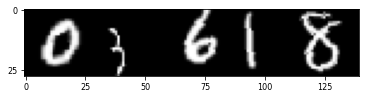

Actual: [2 8 7 5 8]
Predicted: [2 8 7 5 8]


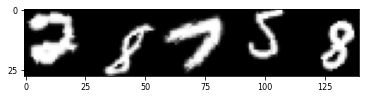

Actual: [6 5 9 4 3]
Predicted: [6 5 9 4 3]


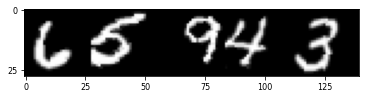

Actual: [4 8 9 0 1]
Predicted: [4 8 9 0 1]


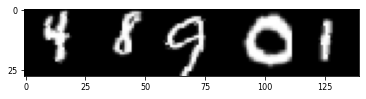

Actual: [6 8 6 1 7]
Predicted: [6 8 6 1 7]


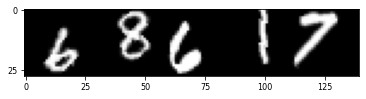

Actual: [7 9 4 5 9]
Predicted: [7 9 4 5 9]


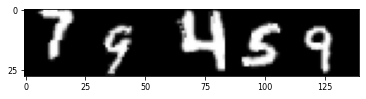

Actual: [1 5 6 6 8]
Predicted: [1 5 6 6 8]


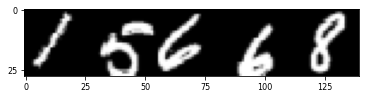

Actual: [0 9 1 4 2]
Predicted: [0 9 1 4 2]


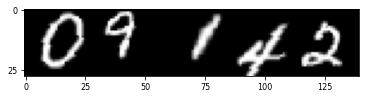

Actual: [8 8 0 3 5]
Predicted: [8 8 0 3 5]


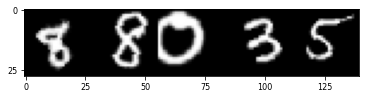

Actual: [0 7 4 9 0]
Predicted: [0 7 4 9 3]


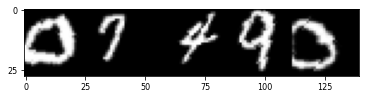

In [47]:
for j in range(len(x_test)):
    mpl.rcParams["font.size"] = 8
    plt.imshow(x_test[j], cmap='gray') # Display image
    mpl.rcParams["font.size"] = 18
    plt.gcf().text(x=0.1, y=0.1, s="Actual: " + str(y_test[j].numpy())) # Show ground-truth text
    plt.gcf().text(x=0.1, y=0.2, s="Predicted: " + str(test_preds[j].numpy())) # Show predicted text
    plt.show()

In [38]:
print(max_index.shape)
max_index

torch.Size([32, 10])


tensor([[10,  2, 10, 10, 10, 10, 10, 10, 10,  0],
        [10,  2,  6,  4, 10,  7,  1,  0,  8, 10],
        [ 0, 10, 10, 10,  6, 10,  1,  0, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10,  5, 10, 10, 10, 10, 10, 10,  7],
        [ 3, 10, 10, 10, 10,  9,  5,  9, 10,  7],
        [10,  8, 10,  8,  8, 10,  5, 10,  8, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10,  0, 10],
        [10, 10, 10, 10,  6, 10,  6, 10,  0, 10],
        [10,  7, 10,  9,  6, 10, 10, 10, 10, 10],
        [ 6,  7,  9, 10, 10,  4, 10, 10, 10,  4],
        [ 6, 10,  9, 10, 10,  4, 10,  1, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],


In [33]:
a = torch.randn(3, 4, 3)
print(a)
print(torch.max(a, dim = 2))

tensor([[[ 1.6259,  0.1115,  1.1555],
         [ 0.5891,  1.2114, -0.2202],
         [ 1.6044,  1.1236, -1.2767],
         [ 0.1598,  0.2967, -0.4562]],

        [[ 1.2766, -1.6382,  0.3821],
         [ 2.1842,  0.3085,  1.5289],
         [-1.9369, -0.8168,  0.7277],
         [ 0.1707,  0.6759, -0.3308]],

        [[-0.0202,  1.2378, -1.2998],
         [-0.4675, -1.4878, -0.6248],
         [ 0.1341,  1.1880, -0.3108],
         [-0.7777,  2.6087, -0.2736]]])
torch.return_types.max(
values=tensor([[ 1.6259,  1.2114,  1.6044,  0.2967],
        [ 1.2766,  2.1842,  0.7277,  0.6759],
        [ 1.2378, -0.4675,  1.1880,  2.6087]]),
indices=tensor([[0, 1, 0, 1],
        [0, 0, 2, 1],
        [1, 0, 1, 1]]))
